In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

from lexical_reflections.utils.device import DEVICE

model = AutoModelForCausalLM.from_pretrained("google/gemma-3-1b-it")
model.to(DEVICE)
model.eval()
tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-1b-it")

# EN-RU


In [3]:
from lexical_reflections.gather_data.hidden_space import collect_hidden_space_by_language
from lexical_reflections.preprocess_data.flores_plus import load_flores_plus

train_df, test_df = load_flores_plus(["eng_Latn", "rus_Cyrl"], {"eng_Latn": "en", "rus_Cyrl": "ru"}, train_size=50)

test_df = test_df[:100]

# { [lang]: torch.tensor([n_layers, n_tokens, d_model]) }
hidden_space_by_language_train = collect_hidden_space_by_language(model, tokenizer, train_df)


Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Data len:  50


100%|██████████| 50/50 [00:08<00:00,  6.14it/s]


In [4]:
import numpy as np
import torch

# last_layer_*: [n_tokens_lang, d_model]
en = hidden_space_by_language_train["en"][-1]
ru = hidden_space_by_language_train["ru"][-1]

# Ensure inputs are PyTorch tensors (hidden space may be numpy arrays)
if isinstance(en, np.ndarray):
    en = torch.from_numpy(en)
if isinstance(ru, np.ndarray):
    ru = torch.from_numpy(ru)

# Ensure floating dtype
en = en.float()
ru = ru.float()

# Global centering
mu0 = torch.cat([en, ru], dim=0).mean(dim=0, keepdim=True)
en_c = en - mu0
ru_c = ru - mu0

# Per-language means (centered)
mu_en = en_c.mean(dim=0, keepdim=True)
mu_ru = ru_c.mean(dim=0, keepdim=True)

# Language-separating direction
Delta = mu_en - mu_ru  # [1, d_model]
u = torch.nn.functional.normalize(Delta, dim=-1)  # unit vector


# Decompose any centered vector x_c into shared + language-specific
def decompose(x):
    x_c = x - mu0
    coeff = x_c @ u.T  # [n_tokens, 1]
    lang_specific = coeff * u  # parallel to Delta
    shared = x_c - lang_specific  # orthogonal (common)
    return shared, lang_specific


shared_en, lang_en = decompose(en)
shared_ru, lang_ru = decompose(ru)

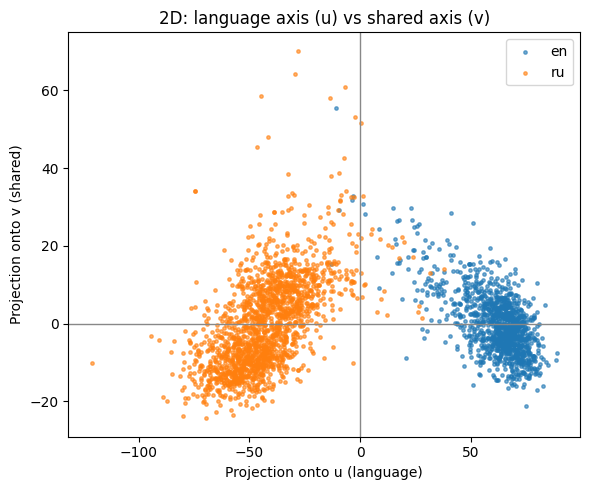

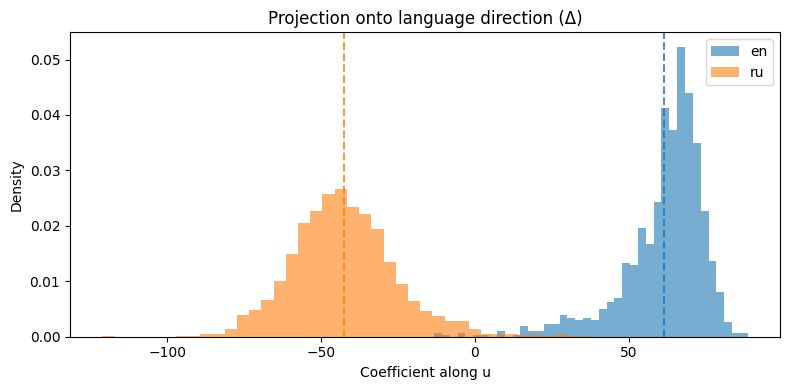

In [5]:
# Project onto language direction (u) and a single shared direction v (orthogonal to u); visualize 2D scatter
import matplotlib.pyplot as plt
import numpy as np

# Coefficients along language direction u
coeff_en_u = ((en - mu0) @ u.T).squeeze(-1)  # [n_en]
coeff_ru_u = ((ru - mu0) @ u.T).squeeze(-1)  # [n_ru]

# Build a single shared direction v: take mean of shared residuals and orthonormalize vs u
shared_cat = torch.cat([shared_en, shared_ru], dim=0)  # [n_total, d]
mean_shared = shared_cat.mean(dim=0, keepdim=True)  # [1, d]
# If mean_shared is near zero, fall back to first QR column on shared_cat^T
if torch.allclose(mean_shared, torch.zeros_like(mean_shared), atol=1e-8):
    M = shared_cat.T  # [d, n_total]
    Q, _ = torch.linalg.qr(M, mode="reduced")  # Q: [d, k]
    v = Q[:, 0:1].T  # [1, d]
else:
    v = mean_shared  # [1, d]

# Orthonormalize v against u (Gram-Schmidt)
v = v - (v @ u.T) * u
v_norm = torch.linalg.norm(v, dim=-1, keepdim=True).clamp_min(1e-12)
v = v / v_norm

# Project onto v
coeff_en_v = ((en - mu0) @ v.T).squeeze(-1)
coeff_ru_v = ((ru - mu0) @ v.T).squeeze(-1)

# To numpy for plotting
coeff_en_u_np = coeff_en_u.cpu().numpy()
coeff_ru_u_np = coeff_ru_u.cpu().numpy()
coeff_en_v_np = coeff_en_v.cpu().numpy()
coeff_ru_v_np = coeff_ru_v.cpu().numpy()

plt.figure(figsize=(6, 5))
plt.scatter(coeff_en_u_np, coeff_en_v_np, s=6, alpha=0.6, label="en")
plt.scatter(coeff_ru_u_np, coeff_ru_v_np, s=6, alpha=0.6, label="ru")
plt.axvline(0.0, color="#888", linewidth=1)
plt.axhline(0.0, color="#888", linewidth=1)
plt.title("2D: language axis (u) vs shared axis (v)")
plt.xlabel("Projection onto u (language)")
plt.ylabel("Projection onto v (shared)")
plt.legend()
plt.tight_layout()
plt.show()

# Also keep histograms along u for separation intuition
plt.figure(figsize=(8, 4))
plt.hist(coeff_en_u_np, bins=40, alpha=0.6, label="en", density=True)
plt.hist(coeff_ru_u_np, bins=40, alpha=0.6, label="ru", density=True)
plt.axvline(coeff_en_u_np.mean(), color="C0", linestyle="--", alpha=0.8)
plt.axvline(coeff_ru_u_np.mean(), color="C1", linestyle="--", alpha=0.8)
plt.title("Projection onto language direction (Δ)")
plt.xlabel("Coefficient along u")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
model

Gemma3ForCausalLM(
  (model): Gemma3TextModel(
    (embed_tokens): Gemma3TextScaledWordEmbedding(262144, 1152, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma3DecoderLayer(
        (self_attn): Gemma3Attention(
          (q_proj): Linear(in_features=1152, out_features=1024, bias=False)
          (k_proj): Linear(in_features=1152, out_features=256, bias=False)
          (v_proj): Linear(in_features=1152, out_features=256, bias=False)
          (o_proj): Linear(in_features=1024, out_features=1152, bias=False)
          (q_norm): Gemma3RMSNorm((256,), eps=1e-06)
          (k_norm): Gemma3RMSNorm((256,), eps=1e-06)
        )
        (mlp): Gemma3MLP(
          (gate_proj): Linear(in_features=1152, out_features=6912, bias=False)
          (up_proj): Linear(in_features=1152, out_features=6912, bias=False)
          (down_proj): Linear(in_features=6912, out_features=1152, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma3RMSNorm((11

In [7]:
original_forward = model.model.norm.forward

In [8]:
import torch
import torch.nn as nn

flip_l = 0
flip_c = 0


class CustomPassthroughLayer(nn.Module):
    def __init__(self, mu0, u, v):
        super().__init__()
        # Expect mu0,u,v as [1, d_model]; store as buffers with shape [1,1,d]
        mu0 = mu0.detach().view(1, 1, -1)
        u = u.detach().view(1, 1, -1)
        v = v.detach().view(1, 1, -1)
        # Normalize u; orthonormalize v against u, then normalize
        u = torch.nn.functional.normalize(u, dim=-1)
        v = v - (v * u).sum(dim=-1, keepdim=True) * u
        v = torch.nn.functional.normalize(v, dim=-1)
        self.register_buffer("mu0", mu0)
        self.register_buffer("u", u)
        self.register_buffer("v", v)

    def forward(self, x):
        # x: [B, T, D]
        mu0 = self.mu0.to(dtype=x.dtype, device=x.device)
        u = self.u.to(dtype=x.dtype, device=x.device)
        v = self.v.to(dtype=x.dtype, device=x.device)
        centered = x - mu0

        # Projections onto language (u) and shared (v) directions
        coeff_u = (centered * u).sum(dim=-1, keepdim=True)  # [B, T, 1]
        proj_u = coeff_u * u  # [B, T, D]
        coeff_v = (centered * v).sum(dim=-1, keepdim=True)  # [B, T, 1]
        proj_v = coeff_v * v  # [B, T, D]

        r = x
        # Use global flip_l / flip_c scalars to adjust components
        # Set flip_l = -1 to remove language component, +1 to amplify, etc.
        if "flip_l" in globals() and flip_l != 0:
            r = r + flip_l * proj_u
        if "flip_c" in globals() and flip_c != 0:
            r = r + flip_c * proj_v
        return r


# Insert the custom layer after model.model.norm using (mu0, u, v) computed above
custom_layer = CustomPassthroughLayer(mu0, u, v)


def new_forward(x):
    x = custom_layer(x)
    x = original_forward(x)
    return x

model.model.norm.forward = new_forward

In [20]:
inputs = tokenizer(["Hello darkness "], return_tensors="pt", add_special_tokens=True)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

flip_l = -3
flip_c = 0

with torch.no_grad():
    generated = model.generate(
        **inputs,
        max_new_tokens=30,
        do_sample=False,  # or True with temperature/top_k for sampling
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )

print(tokenizer.decode(generated[0], skip_special_tokens=True))

Hello darkness 
I не know и the в the в the в the в the in в the in the в the in the в the in the в the in


# EN-CN


# EN-ES


# EN-CN-ES-Arab
